   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
>  1 Headset Microphone (Razer Krake, MME (2 in, 0 out)
   2 Microphone (Razer Barracuda X), MME (1 in, 0 out)
   3 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
<  4 Speakers (FxSound Audio Enhance, MME (0 in, 8 out)
   5 Acer XB240H (NVIDIA High Defini, MME (0 in, 2 out)
   6 Digital Audio (S/PDIF) (High De, MME (0 in, 2 out)
   7 Headset Earphone (Razer Kraken , MME (0 in, 2 out)
   8 Speakers (Razer Barracuda X), MME (0 in, 2 out)
   9 Input (), Windows WDM-KS (8 in, 0 out)
  10 Speakers (), Windows WDM-KS (0 in, 8 out)
  11 SPDIF Out (HD Audio SPDIF out), Windows WDM-KS (0 in, 2 out)
  12 Headset Microphone (), Windows WDM-KS (2 in, 0 out)
  13 Headset Earphone (), Windows WDM-KS (0 in, 2 out)
  14 Output (), Windows WDM-KS (0 in, 2 out)
  15 Microphone (Razer Barracuda X), Windows WDM-KS (1 in, 0 out)
  16 Speakers (Razer Barracuda X), Windows WDM-KS (0 in, 2 out)
(220000, 1)
-2.5690252130681817e-06


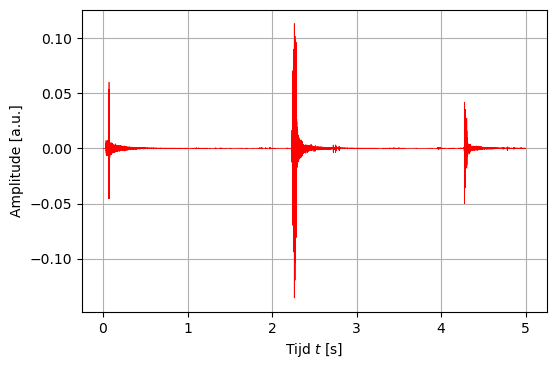

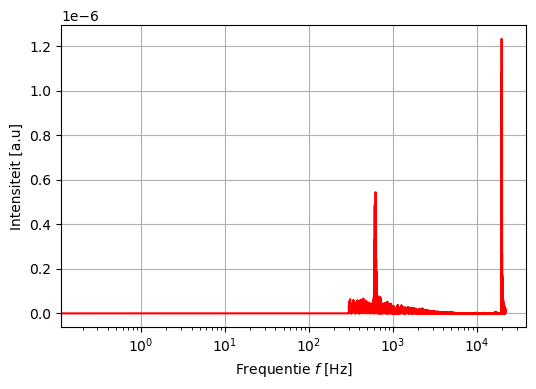

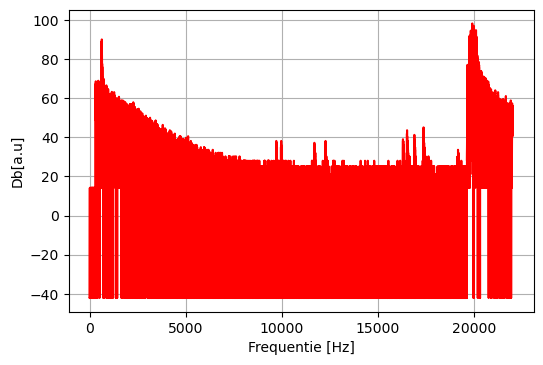

C:\Users\Chris\AppData\Local\Temp/ipykernel_24092/1757246523.py:74: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(label="Beta dB [a.u.]", norm=True)


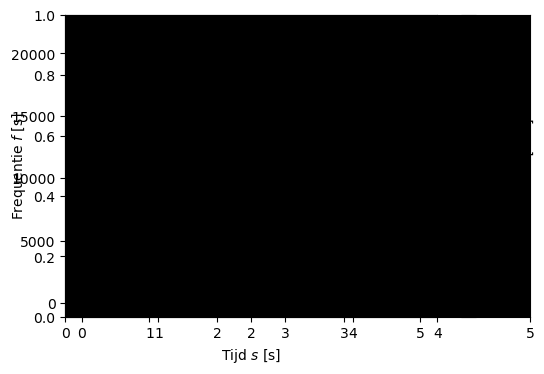

17.8014508176998

In [4]:
import sounddevice as sd
import matplotlib.pyplot as plt
import numpy as np
from mijngeluid import fft_partitioned # zet mijngeluid.py in dezelfde folder als je notebook
import math
#import pandas as pd

def meting():
    print(sd.query_devices()) # geeft een lijst met devices en de bijbehorende nummers
    fs = 44000 
    duration = 5
    amp_ref = 0.0001
    arr = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='float64', device=1) # neemt op in de achtergrond
    Io = 1e-12

    print(arr.shape)
    sd.wait()
    gemiddelde = np.average(arr)
    t = np.linspace(0, duration, int(fs*duration)) # maak (voor het gemak) een tijd as
    plt.figure(dpi=100)
    plt.plot(t, arr, 'r-', ms=0.5, lw=0.5)
    plt.grid()
    plt.xlabel(r"Tijd $t$ [s]")
    plt.ylabel(r"Amplitude [a.u.]") # arbitrary units (we hebben niets gekalibreerd)
    plt.plot()
    print(gemiddelde)
    N = int(fs*duration) # Nsamples in signaal
    T = duration/N # Sampling tijd

    fhat = np.fft.fft(arr)
    x = np.linspace(0.0, 1.0/(2.0*T), N//2) # frequentie
    y = 2.0/N * np.abs(fhat[:N//2]) # Intensteit ||.||^2

    plt.figure(dpi=100)
    plt.plot(x,y, 'r-')
    plt.grid()
    #plt.yscale("log")
    plt.xscale("log")
    plt.xlabel(r"Frequentie $f$ [Hz]")
    plt.ylabel(r"Intensiteit [a.u]")
    #print(y)

    y1 = y.tolist()
    #print(y1)
    y2 = [i[0] for i in y1]

    y2 = np.array(y2)
    y2[y2==0]=1e-12

    y3 = y2.tolist()
    y4 = []
    for I in y3:
        y4.append((10*(math.log(I/Io))) - 42.11)



    plt.figure(dpi=100)
    plt.plot(x,y4, 'r-')
    plt.xlabel(r"Frequentie [Hz]")
    plt.ylabel(r"Db[a.u]")
    plt.grid()
    plt.show()

    plt.figure(dpi=100)


    df = fft_partitioned(arr[:,0], fs, t_tot=arr.shape[0]/fs, t_bin=1e-2)

    b1 = df.t
    a1 = df.f


    plt.scatter(b1, a1, c=y4, cmap='cool', marker='.' ,s=1)
    plt.colorbar(label="Beta dB [a.u.]", norm=True)
    plt.xlabel("Tijd $s$ [s]")
    #plt.ylim(1000,1005)
    ax = plt.axes()
    ax.set_facecolor("black")
    plt.ylabel("Frequentie $f$ [s]")
    plt.xlim(0,5)

    plt.show()

    #voor 3d plot:

    gemiddelde = np.average(y4)
    file = open("Metingen.txt", "a")
    file.write(str(gemiddelde))
    file.write("\n")
    file.close()
    return gemiddelde

meting()


